In [1]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from cuqi.model import LinearModel
from cuqi.distribution import Gaussian, JointDistribution, ModifiedHalfNormal, Gamma
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF,RegularizedUnboundedUniform, ConstrainedGaussian, ConstrainedGMRF
from cuqi.experimental.mcmc import RegularizedLinearRTO, LinearRTO, Conjugate, HybridGibbs

In [2]:
# Define model and data

np.random.seed(88)

A_matrix = np.array([[1.0, 1.0]])
A = LinearModel(A_matrix)

x_true = np.array([1.5, 1.5])
y = Gaussian(A@x_true, 0.1)

x_true = np.array([1.5, 1.5])
y = Gaussian(A@x_true, 0.1)
y_data = np.array([y.sample()])
print(y_data)

[3.03379978]


In [34]:
experiments = [
    (Gaussian(np.zeros(2), 10), LinearRTO, "Gaussian"),
    (ConstrainedGaussian(np.zeros(2), 10, constraint="nonnegativity"), RegularizedLinearRTO, "Nonnegativity"),
    (RegularizedGaussian(np.zeros(2), 10, regularization="TV", strength = 0.2, geometry = A.domain_geometry), RegularizedLinearRTO, "TV"),
    ]

In [35]:
num_samples = 200
samples = np.zeros((len(experiments), 2, num_samples))

for i, (x, sampler_class, _) in enumerate(experiments):
    print(x, sampler_class)

    y = Gaussian(A@x, 0.1)
    joint = JointDistribution(x,y)
    posterior = joint(y = y_data)
    if i == 2:
        sampler = sampler_class(posterior, maxit = 500, penalty_parameter = 1000)
    else:
        sampler = sampler_class(posterior, maxit = 500)

    np.random.seed(88)
    sampler.sample(num_samples)
    samples[i, :, :] = sampler.get_samples().samples

CUQI Gaussian. <class 'cuqi.experimental.mcmc._rto.LinearRTO'>


Sample: 100%|██████████| 200/200 [00:00<00:00, 711.70it/s, acc rate: 100.00%]


CUQI ConstrainedGaussian. <class 'cuqi.experimental.mcmc._rto.RegularizedLinearRTO'>


Sample: 100%|██████████| 200/200 [00:04<00:00, 45.66it/s, acc rate: 100.00%]


CUQI RegularizedGaussian. <class 'cuqi.experimental.mcmc._rto.RegularizedLinearRTO'>


Sample: 100%|██████████| 200/200 [00:42<00:00,  4.75it/s, acc rate: 100.00%]


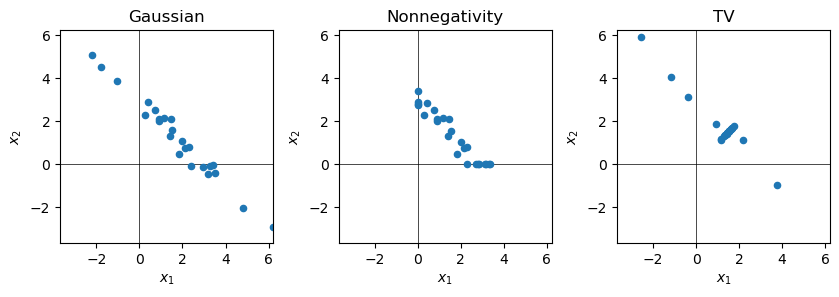

In [36]:
indices = np.linspace(0, num_samples-1, 25, dtype=int)

x_min = np.min(samples[:, 0, indices])
x_max = np.max(samples[:, 0, indices])
y_min = np.min(samples[:, 1, indices])
y_max = np.max(samples[:, 1, indices])
min_val = min(x_min, y_min)
max_val = min(x_max, y_max)

plt.figure(figsize = (8.5,3))
for i, (x, sampler_class, name) in enumerate(experiments):
    plt.subplot(1,3,i+1)
    plt.gca().axhline(y=0, color='k', lw = 0.5, zorder = 1)
    plt.gca().axvline(x=0, color='k', lw = 0.5, zorder = 1)

    plt.scatter(samples[i, 0, indices], samples[i, 1, indices], s = 20, zorder = 2)
    plt.title(name)
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

plt.tight_layout()
#plt.savefig("figures//simplest_samples.pdf")

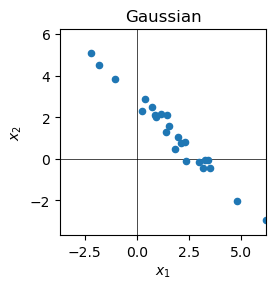

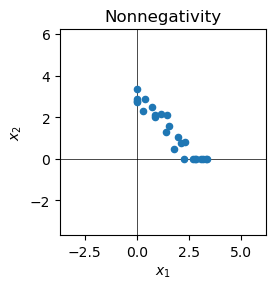

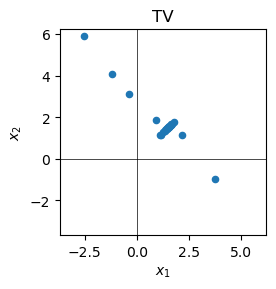

In [31]:
indices = np.linspace(0, num_samples-1, 25, dtype=int)

x_min = np.min(samples[:, 0, indices])
x_max = np.max(samples[:, 0, indices])
y_min = np.min(samples[:, 1, indices])
y_max = np.max(samples[:, 1, indices])
min_val = min(x_min, y_min)
max_val = min(x_max, y_max)

for i, (x, sampler_class, name) in enumerate(experiments):
    plt.figure(figsize = (3,3))
    plt.gca().axhline(y=0, color='k', lw = 0.5, zorder = 1)
    plt.gca().axvline(x=0, color='k', lw = 0.5, zorder = 1)

    plt.scatter(samples[i, 0, indices], samples[i, 1, indices], s = 20, zorder = 2)
    plt.title(name)
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

    plt.tight_layout()
    plt.savefig("figures//simplest_samples_"+name+".pdf")
    plt.show()


In [71]:
num_samples = 1000
d = Gamma(1, 1e-4)
l = Gamma(1, 1e-4)

x = RegularizedUnboundedUniform(regularization="TV", strength = lambda d : d,
                                geometry = A.domain_geometry)
y = Gaussian(A@x, prec = lambda l : l)
posterior = JointDistribution(d,l,x,y)(y = y_data)

sampling_strategy = {
            'd': Conjugate(),
            'l': Conjugate(),
            'x': RegularizedLinearRTO(maxit = 500, penalty_parameter = 1000)
            }

sampler = HybridGibbs(posterior, sampling_strategy)
sampler.sample(num_samples)
gibbs_samples_x = sampler.get_samples()['x'].burnthin(50).samples
gibbs_samples_d = sampler.get_samples()['d'].burnthin(50).samples
gibbs_samples_l = sampler.get_samples()['l'].burnthin(50).samples

c:\Users\jmev\Documents\git_repos\CUQIpy\cuqi\distribution\_gaussian.py:681: RuntimeWarning: divide by zero encountered in log
  logdet = np.sum(-np.log(precision))
Sample:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jmev\Documents\git_repos\CUQIpy\cuqi\solver\_solver.py:343: RuntimeWarning: invalid value encountered in scalar divide
  p = s + (gamma/gamma1)*p
Sample: 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


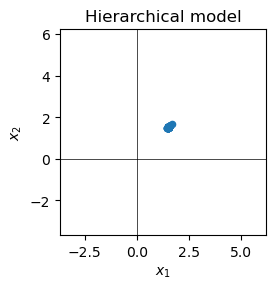

In [76]:
    plt.figure(figsize = (3,3))
    plt.gca().axhline(y=0, color='k', lw = 0.5, zorder = 1)
    plt.gca().axvline(x=0, color='k', lw = 0.5, zorder = 1)

    plt.scatter(gibbs_samples_x[0, :], gibbs_samples_x[1, :], s = 20, zorder = 2)
    plt.title("Hierarchical model")
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.savefig("figures//simplest_samples_hierarchical.pdf")

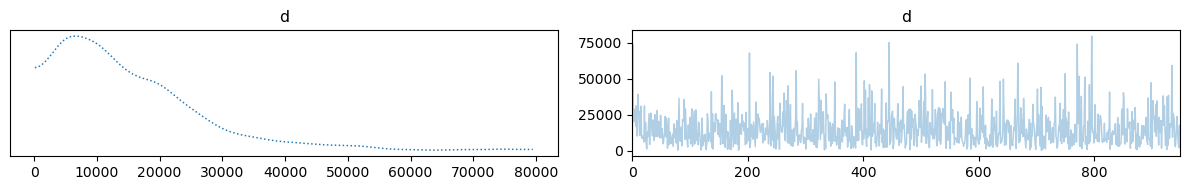

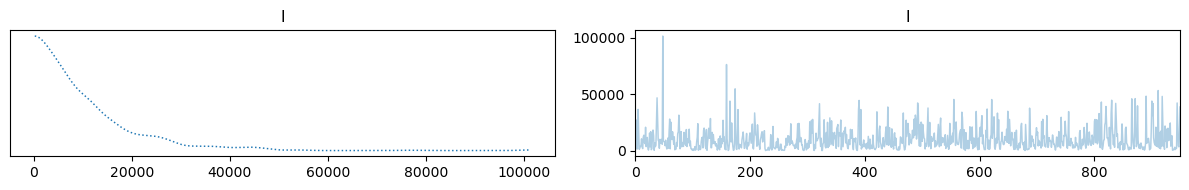

In [77]:
sampler.get_samples()['d'].burnthin(50).plot_trace()
plt.savefig("figures//simplest_samples_delta.pdf")

sampler.get_samples()['l'].burnthin(50).plot_trace()
plt.savefig("figures//simplest_samples_lambda.pdf")